Compare different SMOTE variants on the original band data

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import os, pickle, itertools
import numpy as np
import pandas as pd

import smote_variants as sv

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import utils
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.inspection import permutation_importance
import sklearn.inspection as ip

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Init

In [4]:
with open('../data/multiclass_all_bands.pkl', 'rb') as fin:
    data = pickle.load(fin)

## Functions

In [5]:
def cross_validation(data, target, spliter, sampler, model):
    
    result = []
    for train_index, test_index in spliter.split(data, target):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        if sampler == None:
            X_samp, y_samp = X_train, y_train
        else:
            X_samp, y_samp = sampler.sample(X_train, y_train)

        model.fit(X_samp, y_samp)
        y_pred = model.predict(X_test)

        result.append([y_test, y_pred])
    return result

In [6]:
def evaluate_global(results):
    for r,i in zip(results, range(len(results))):
        print('-------- {} --------'.format(i))
        print('Accuracy: {:.4f}'.format(metrics.accuracy_score(r[0], r[1])))
        print('Precision: {:.4f}'.format(metrics.precision_score(r[0], r[1], average='macro')))
        print('Recall: {:.4f}'.format(metrics.recall_score(r[0], r[1], average='macro')))
        print('F1: {:.4f}'.format(metrics.f1_score(r[0], r[1], average='macro'))) 

In [7]:
def evaluate_classes(result, names, sort='F1-score', ascending=False):
    prfs = metrics.precision_recall_fscore_support(result[0], result[1], average=None)
    metrics_table = pd.DataFrame({'Label':names, 'Precision': prfs[0], 'Recall':prfs[1], 'F1-score':prfs[2]})
    return metrics_table.sort_values(sort, ascending=ascending)

In [8]:
def plot_confusion_matrix(result, scale=False):
    cm = metrics.confusion_matrix(result[0], result[1])
    if scale == True:
        cm = cm / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(11,10))
    ax = sns.heatmap(cm , cmap="YlGnBu", xticklabels=data['name'], yticklabels=data['name'])
    blim, tlim = ax.get_ylim()
    ax = ax.set_ylim(blim+0.5, tlim-0.5)

In [9]:
def false_predictions(result, names, label, sort='sum', ascending=False):
    code = np.where(names == label)[0][0]
    trues = result[0]
    preds = result[1]
    
    # fasle negative
    wrongs = []
    for t, p in zip(trues, preds):
        if t == code and p != code:
            wrongs.append(p)
    fn = pd.DataFrame(np.unique([names[x] for x in wrongs], return_counts=True)).transpose().rename(columns={0:'name', 1:'false_neg'})
    
    # false postive
    wrongs = []
    for t, p in zip(trues, preds):
        if t != code and p == code:
            wrongs.append(t)
    fp = pd.DataFrame(np.unique([names[x]  for x in wrongs], return_counts=True)).transpose().rename(columns={0:'name', 1:'false_pos'})
    
    # combine
    false_preds = pd.merge(fn, fp, how='outer', on='name')
    false_preds = false_preds.fillna(0)
    false_preds['sum'] = false_preds['false_neg'] + false_preds['false_pos']
    
    false_preds = false_preds.sort_values(sort, ascending=ascending)
    return false_preds

In [10]:
def organ_labels(result, names):
    trues = result[0]
    preds = result[1]
    
    label2organ = {}
    for v,i in zip(names, range(len(names))):
        label2organ[i] = v.split(' ')[0]
        
    trues_org = [label2organ[x] for x in trues]
    preds_org = [label2organ[x] for x in preds]
    return [trues_org, preds_org]

In [11]:
def get_organs(names):
    organs = []
    for i in names:
        organs.append(i.split(' ')[0])
    return np.unique(organs)

In [12]:
def under_sample(data, label, samples):
    
    target_idx = np.where(data['label'] == label)[0]

    samples = target_idx.shape[0] - samples
    exclude_idx = utils.resample(target_idx, n_samples=samples, replace=False)

    mask = np.ones(data['data'].shape[0], bool)
    mask[exclude_idx] = False

    us_data = data['data'][mask]
    us_target = data['target'][mask]
    
    return [us_data, us_target]

## Comparisons of smote methods (grid)

Initial comparison shows "prportion" and "n_estimators" both affect performance

Undersampling is very useful

SMOTE_IPF is TOO slow

In [ ]:
oversamplers = [sv.MulticlassOversampling(sv.ProWSyn(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.ProWSyn(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOTE_IPF(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOTE_IPF(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOTE_IPF(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.Lee(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.Lee(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.Lee(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOBD(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOBD(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOBD(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.G_SMOTE(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.G_SMOTE(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.G_SMOTE(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.CCR(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.CCR(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.CCR(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.LVQ_SMOTE(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.LVQ_SMOTE(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.LVQ_SMOTE(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.Assembled_SMOTE(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.Assembled_SMOTE(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.Assembled_SMOTE(proportion=5.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOTE_TomekLinks(proportion=0.1, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOTE_TomekLinks(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOTE_TomekLinks(proportion=5.0, n_jobs=-1))
                ]

models = [RandomForestClassifier(n_estimators=1000, n_jobs=-1),
          RandomForestClassifier(n_estimators=2000, n_jobs=-1),
        ]

spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

under_samples = [0, 1700, 2500]

all_res = []

for sampler in oversamplers:
    sampler_res = []
    for model in models:
        model_res = []
        
        for us in under_samples:
            if us == 0:
                sm = None
                d = data['data']
                t = data['target']
            else:
                sm = sampler
                d, t = under_sample(data, 'Breast Infiltrating duct carcinoma', us)

            result = cross_validation(d, t, 
                                    spliter = spliter,
                                    sampler = sm,
                                    model = model)
            
            print('{} {} {}'.format(sampler, model, us))
            
            model_res.append(result)
        sampler_res.append(model_res)
    all_res.append(sampler_res)

In [16]:
for s, i in zip(all_res, range(len(all_res))):
    print(' ############# SAMPLER {} ##########'.format(i))
    for m,j in zip(s,range(len(s))):
        print('***** model {} ***'.format(j))
        for t in m:
            evaluate_global(t)

 ############# SAMPLER 0 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6007
Precision: 0.5469
Recall: 0.2698
F1: 0.3015
-------- 0 --------
Accuracy: 0.6267
Precision: 0.5130
Recall: 0.4834
F1: 0.4873
-------- 0 --------
Accuracy: 0.6145
Precision: 0.5084
Recall: 0.4792
F1: 0.4819
***** model 1 ***
-------- 0 --------
Accuracy: 0.5903
Precision: 0.5015
Recall: 0.2628
F1: 0.2929
-------- 0 --------
Accuracy: 0.6331
Precision: 0.5303
Recall: 0.4724
F1: 0.4839
-------- 0 --------
Accuracy: 0.6178
Precision: 0.4981
Recall: 0.4671
F1: 0.4726
 ############# SAMPLER 1 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.5938
Precision: 0.5002
Recall: 0.2687
F1: 0.3043
-------- 0 --------
Accuracy: 0.6237
Precision: 0.5064
Recall: 0.4781
F1: 0.4838
-------- 0 --------
Accuracy: 0.6268
Precision: 0.5227
Recall: 0.4701
F1: 0.4840
***** model 1 ***
-------- 0 --------
Accuracy: 0.5891
Precision: 0.5124
Recall: 0.2676
F1: 0.3006
-------- 0 --------
Accuracy: 0.6299
Precision

/Users/bogao/anaconda3/envs/smoten/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bogao/anaconda3/envs/smoten/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.2710
F1: 0.3067
-------- 0 --------
Accuracy: 0.6166
Precision: 0.5043
Recall: 0.4723
F1: 0.4775
-------- 0 --------
Accuracy: 0.6268
Precision: 0.5193
Recall: 0.4738
F1: 0.4852
 ############# SAMPLER 3 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6050
Precision: 0.5627
Recall: 0.2719
F1: 0.3048
-------- 0 --------
Accuracy: 0.6244
Precision: 0.5304
Recall: 0.4827
F1: 0.4931
-------- 0 --------
Accuracy: 0.6236
Precision: 0.5172
Recall: 0.4507
F1: 0.4636
***** model 1 ***
-------- 0 --------
Accuracy: 0.5976
Precision: 0.5545
Recall: 0.2650
F1: 0.2990
-------- 0 --------
Accuracy: 0.6160
Precision: 0.5174
Recall: 0.4552
F1: 0.4675
-------- 0 --------
Accuracy: 0.6275
Precision: 0.5049
Recall: 0.4563
F1: 0.4698
 ############# SAMPLER 4 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6023
Precision: 0.5293
Recall: 0.2674
F1: 0.2972
-------- 0 --------
Accuracy: 0.6246
Precision: 0.5227
Recall: 0.4652
F1: 0.4805
-------- 0 --------
Accuracy: 0.6272
P

In [18]:
with open('../data/smote_grid_pws_ipf.pkl', 'wb') as fo:
    pickle.dump(all_res, fo)

In [27]:
22671-18714

3957

## Qucik comparison of SMOTE methods

In [ ]:
oversamplers = [
                sv.MulticlassOversampling(sv.Lee(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOBD(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.G_SMOTE(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.CCR(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.LVQ_SMOTE(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.Assembled_SMOTE(proportion=1.0, n_jobs=-1)),
                sv.MulticlassOversampling(sv.SMOTE_TomekLinks(proportion=1.0, n_jobs=-1)),
                ]

models = [RandomForestClassifier(n_estimators=1000, n_jobs=-1),
        ]

spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

under_samples = [1700]

all_res = []

for sampler in oversamplers:
    sampler_res = []
    for model in models:
        model_res = []
        
        for us in under_samples:
            print('{}'.format(sampler))
            
            if us == 0:
                sm = None
                d = data['data']
                t = data['target']
            else:
                sm = sampler
                d, t = under_sample(data, 'Breast Infiltrating duct carcinoma', us)

            result = cross_validation(d, t, 
                                    spliter = spliter,
                                    sampler = sm,
                                    model = model)
            
            
            
            model_res.append(result)
        sampler_res.append(model_res)
    all_res.append(sampler_res)

In [15]:
for s, i in zip(all_res, range(len(all_res))):
    print(' ############# SAMPLER {} ##########'.format(i))
    for m,j in zip(s,range(len(s))):
        print('***** model {} ***'.format(j))
        for t in m:
            evaluate_global(t)

 ############# SAMPLER 0 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6180
Precision: 0.5333
Recall: 0.4584
F1: 0.4745
 ############# SAMPLER 1 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6116
Precision: 0.5056
Recall: 0.4416
F1: 0.4565
 ############# SAMPLER 2 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6196
Precision: 0.5402
Recall: 0.4052
F1: 0.4320
 ############# SAMPLER 3 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.5995
Precision: 0.5308
Recall: 0.3325
F1: 0.3616
 ############# SAMPLER 4 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6057
Precision: 0.5428
Recall: 0.3458
F1: 0.3749
 ############# SAMPLER 5 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6214
Precision: 0.5429
Recall: 0.4560
F1: 0.4731
 ############# SAMPLER 6 ##########
***** model 0 ***
-------- 0 --------
Accuracy: 0.6246
Precision: 0.5391
Recall: 0.4602
F1: 0.4788


/Users/bogao/anaconda3/envs/smoten/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bogao/anaconda3/envs/smoten/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
false_predictions(result_basic[1], data['name'], 'Lung Small cell carcinoma')

,name,false_neg,false_pos,sum
1,Breast Infiltrating duct carcinoma,28,0.0,28.0
4,Lung Non-small cell carcinoma,4,0.0,4.0
0,Brain Glioma,3,0.0,3.0
5,Ovary Carcinoma,3,0.0,3.0
6,Skin Melanoma,3,0.0,3.0
2,Cerebellum Medulloblastoma,2,0.0,2.0
3,Lung Adenocarcinoma,1,0.0,1.0


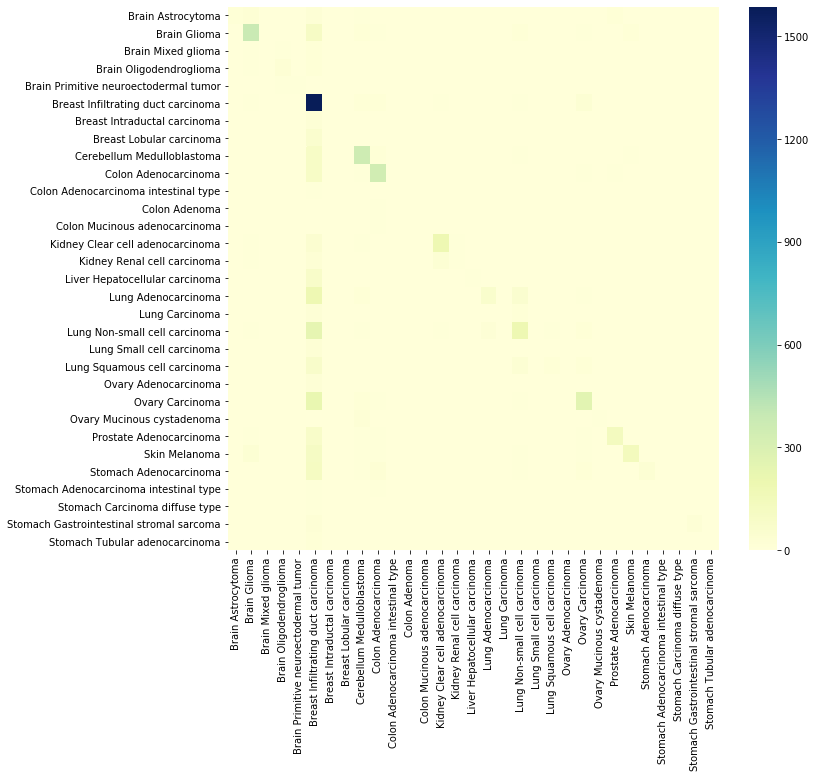

In [14]:
plot_confusion_matrix(result_basic[1])

### organ

In [36]:
result_basic_organ = organ_labels(result_basic[1], data['name'])

In [50]:
evaluate_global([result_basic_organ])

-------- 0 --------
Accuracy: 0.6150
Precision: 0.7218
Recall: 0.5062
F1: 0.5431


In [64]:
evaluate_classes(result_basic_organ, get_organs(data['name']))

,Label,Precision,Recall,F1-score
0,Brain,0.804916,0.643735,0.715358
4,Kidney,0.820690,0.632979,0.714715
3,Colon,0.723866,0.670932,0.696395
2,Cerebellum,0.671642,0.712871,0.691643
1,Breast,0.495405,0.937710,0.648303
8,Prostate,0.653846,0.494545,0.563147
7,Ovary,0.642686,0.447412,0.527559
9,Skin,0.665049,0.428125,0.520913
6,Lung,0.780899,0.370996,0.503016
10,Stomach,0.805556,0.166189,0.275534


## Basic ProWsyn

In [ ]:
result_proWsyn = cross_validation(data['data'], data['target'], 
                                spliter = StratifiedShuffleSplit(n_splits=2, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn()),
                                model = RandomForestClassifier(n_estimators=200, n_jobs=-1))

### disease

In [30]:
evaluate_global(result_proWsyn)

-------- 0 --------
Accuracy: 0.5791
Precision: 0.4134
Recall: 0.4089
F1: 0.4042
-------- 1 --------
Accuracy: 0.5775
Precision: 0.4272
Recall: 0.4256
F1: 0.4190


In [31]:
evaluate_classes(result_proWsyn[1])

,Label,Precision,Recall,F1-score
6,Breast Intraductal carcinoma,0.809524,0.680000,0.739130
13,Kidney Clear cell adenocarcinoma,0.659824,0.806452,0.725806
1,Brain Glioma,0.735849,0.689046,0.711679
8,Cerebellum Medulloblastoma,0.618067,0.772277,0.686620
5,Breast Infiltrating duct carcinoma,0.629349,0.735415,0.678261
9,Colon Adenocarcinoma,0.677215,0.651116,0.663909
22,Ovary Carcinoma,0.651613,0.570621,0.608434
24,Prostate Adenocarcinoma,0.573379,0.610909,0.591549
29,Stomach Gastrointestinal stromal sarcoma,0.514706,0.660377,0.578512
25,Skin Melanoma,0.594262,0.453125,0.514184


### organ

In [65]:
result_proWsyn_organ = organ_labels(result_proWsyn[1], data['name'])

In [66]:
evaluate_global([result_proWsyn_organ])

-------- 0 --------
Accuracy: 0.6604
Precision: 0.6282
Recall: 0.6230
F1: 0.6203


In [67]:
evaluate_classes(result_proWsyn_organ, get_organs(data['name']))

,Label,Precision,Recall,F1-score
0,Brain,0.778796,0.730958,0.754119
4,Kidney,0.650759,0.797872,0.716846
1,Breast,0.649544,0.759259,0.700129
3,Colon,0.691606,0.692870,0.692237
2,Cerebellum,0.618067,0.772277,0.686620
6,Lung,0.718310,0.544484,0.619433
7,Ovary,0.646840,0.580968,0.612137
8,Prostate,0.573379,0.610909,0.591549
9,Skin,0.594262,0.453125,0.514184
10,Stomach,0.573643,0.424069,0.487644


### compare basic & proWsyn

In [71]:
pd.merge(evaluate_classes(result_basic[0], data['name']),
         evaluate_classes(result_proWsyn[1], data['name']),
         how = 'right',
         on='Label',
         suffixes=['_basic', '_proWsyn'])

,Label,Precision_basic,Recall_basic,F1-score_basic,Precision_proWsyn,Recall_proWsyn,F1-score_proWsyn
0,Colon Adenocarcinoma,0.688931,0.732252,0.709931,0.677215,0.651116,0.663909
1,Kidney Clear cell adenocarcinoma,0.708487,0.688172,0.698182,0.659824,0.806452,0.725806
2,Brain Glioma,0.693262,0.690813,0.692035,0.735849,0.689046,0.711679
3,Cerebellum Medulloblastoma,0.645390,0.720792,0.681010,0.618067,0.772277,0.686620
4,Breast Infiltrating duct carcinoma,0.476047,0.931055,0.629984,0.629349,0.735415,0.678261
5,Stomach Gastrointestinal stromal sarcoma,0.857143,0.452830,0.592593,0.514706,0.660377,0.578512
6,Prostate Adenocarcinoma,0.631841,0.461818,0.533613,0.573379,0.610909,0.591549
7,Ovary Carcinoma,0.618090,0.463277,0.529602,0.651613,0.570621,0.608434
8,Skin Melanoma,0.685864,0.409375,0.512720,0.594262,0.453125,0.514184
9,Brain Oligodendroglioma,0.538462,0.424242,0.474576,0.412698,0.393939,0.403101


In [73]:
pd.merge(evaluate_classes(result_basic_organ, get_organs(data['name'])),
         evaluate_classes(result_proWsyn_organ, get_organs(data['name'])),
         how = 'right',
         on='Label',
         suffixes=['_basic', '_proWsyn'])

,Label,Precision_basic,Recall_basic,F1-score_basic,Precision_proWsyn,Recall_proWsyn,F1-score_proWsyn
0,Brain,0.804916,0.643735,0.715358,0.778796,0.730958,0.754119
1,Kidney,0.820690,0.632979,0.714715,0.650759,0.797872,0.716846
2,Colon,0.723866,0.670932,0.696395,0.691606,0.692870,0.692237
3,Cerebellum,0.671642,0.712871,0.691643,0.618067,0.772277,0.686620
4,Breast,0.495405,0.937710,0.648303,0.649544,0.759259,0.700129
5,Prostate,0.653846,0.494545,0.563147,0.573379,0.610909,0.591549
6,Ovary,0.642686,0.447412,0.527559,0.646840,0.580968,0.612137
7,Skin,0.665049,0.428125,0.520913,0.594262,0.453125,0.514184
8,Lung,0.780899,0.370996,0.503016,0.718310,0.544484,0.619433
9,Stomach,0.805556,0.166189,0.275534,0.573643,0.424069,0.487644


## All bands

In [74]:
with open('../data/multiclass_all_bands.pkl', 'rb') as fin:
    bands = pickle.load(fin)

### basic model

In [75]:
result_bands_basic = cross_validation(bands['data'], bands['target'], 
                                spliter = StratifiedShuffleSplit(n_splits=2, test_size=0.3),
                                sampler = None,
                                model = RandomForestClassifier(n_estimators=200, n_jobs=-1))

#### disease

In [76]:
evaluate_global(result_bands_basic)

-------- 0 --------
Accuracy: 0.5967
Precision: 0.5368
Recall: 0.2690
F1: 0.3020
-------- 1 --------
Accuracy: 0.5898
Precision: 0.4894
Recall: 0.2644
F1: 0.2961


/Users/bogao/anaconda3/envs/smoten/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bogao/anaconda3/envs/smoten/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### organ

In [77]:
result_bands_basic_organ = organ_labels(result_bands_basic[0], bands['name'])

In [78]:
evaluate_global([result_bands_basic_organ])

-------- 0 --------
Accuracy: 0.6608
Precision: 0.7805
Recall: 0.5590
F1: 0.5985


### Basic ProWsyn

In [ ]:
result_bands_proWsyn = cross_validation(bands['data'], bands['target'], 
                                spliter = StratifiedShuffleSplit(n_splits=2, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn()),
                                model = RandomForestClassifier(n_estimators=200, n_jobs=-1))

#### disease

In [80]:
evaluate_global(result_bands_proWsyn)

-------- 0 --------
Accuracy: 0.6341
Precision: 0.4907
Recall: 0.4513
F1: 0.4600
-------- 1 --------
Accuracy: 0.6367
Precision: 0.5354
Recall: 0.4606
F1: 0.4784


#### organ

In [81]:
result_bands_proWsyn_organ = organ_labels(result_bands_proWsyn[1], bands['name'])

In [82]:
evaluate_global([result_bands_proWsyn_organ])

-------- 0 --------
Accuracy: 0.7173
Precision: 0.7064
Recall: 0.6803
F1: 0.6858


#### compare basic & proWsyn

In [83]:
pd.merge(evaluate_classes(result_bands_basic[0], bands['name']),
         evaluate_classes(result_bands_proWsyn[1], bands['name']),
         how = 'right',
         on='Label',
         suffixes=['_basic', '_proWsyn'])

/Users/bogao/anaconda3/envs/smoten/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Label,Precision_basic,Recall_basic,F1-score_basic,Precision_proWsyn,Recall_proWsyn,F1-score_proWsyn
0,Kidney Clear cell adenocarcinoma,0.778947,0.795699,0.787234,0.666667,0.831541,0.740032
1,Brain Glioma,0.723958,0.736749,0.730298,0.730337,0.689046,0.709091
2,Colon Adenocarcinoma,0.680581,0.760649,0.718391,0.660107,0.748479,0.701521
3,Cerebellum Medulloblastoma,0.650086,0.750495,0.696691,0.632166,0.786139,0.700794
4,Prostate Adenocarcinoma,0.775701,0.603636,0.678937,0.674121,0.767273,0.717687
5,Breast Infiltrating duct carcinoma,0.503724,0.956394,0.659890,0.671620,0.825575,0.740682
6,Ovary Carcinoma,0.749354,0.546139,0.631808,0.714932,0.595104,0.649538
7,Skin Melanoma,0.759162,0.453125,0.567515,0.688525,0.525000,0.595745
8,Stomach Gastrointestinal stromal sarcoma,0.909091,0.377358,0.533333,0.553191,0.490566,0.520000
9,Brain Oligodendroglioma,0.519231,0.409091,0.457627,0.543860,0.469697,0.504065


In [84]:
pd.merge(evaluate_classes(result_bands_basic_organ, get_organs(bands['name'])),
         evaluate_classes(result_bands_proWsyn_organ, get_organs(bands['name'])),
         how = 'right',
         on='Label',
         suffixes=['_basic', '_proWsyn'])

,Label,Precision_basic,Recall_basic,F1-score_basic,Precision_proWsyn,Recall_proWsyn,F1-score_proWsyn
0,Kidney,0.865815,0.720745,0.786647,0.724942,0.827128,0.772671
1,Brain,0.851796,0.699017,0.767881,0.821095,0.755528,0.786948
2,Colon,0.734657,0.744059,0.739328,0.699515,0.791590,0.742710
3,Cerebellum,0.650086,0.750495,0.696691,0.632166,0.786139,0.700794
4,Breast,0.527261,0.955107,0.679441,0.693129,0.837823,0.758638
5,Prostate,0.775701,0.603636,0.678937,0.674121,0.767273,0.717687
6,Ovary,0.762500,0.509182,0.610611,0.728175,0.612688,0.665458
7,Skin,0.759162,0.453125,0.567515,0.688525,0.525000,0.595745
8,Lung,0.848921,0.419929,0.561905,0.805489,0.600534,0.688073
9,Stomach,0.809524,0.194842,0.314088,0.636364,0.421203,0.506897


In [87]:
comp_bands = pd.merge(evaluate_classes(result_bands_basic_organ, get_organs(bands['name']))[['Label','F1-score']],
         evaluate_classes(result_bands_proWsyn_organ, get_organs(bands['name']))[['Label','F1-score']],
         how = 'right',
         on='Label',
         suffixes=['_basic', '_proWsyn'])
comp_genes = pd.merge(evaluate_classes(result_basic_organ, get_organs(data['name']))[['Label','F1-score']],
         evaluate_classes(result_proWsyn_organ, get_organs(data['name']))[['Label','F1-score']],
         how = 'right',
         on='Label',
         suffixes=['_basic', '_proWsyn'])

pd.merge(comp_bands,
         comp_genes,
         how = 'right',
         on='Label',
         suffixes=['_bands', '_genes'])

,Label,F1-score_basic_bands,F1-score_proWsyn_bands,F1-score_basic_genes,F1-score_proWsyn_genes
0,Kidney,0.786647,0.772671,0.714715,0.716846
1,Brain,0.767881,0.786948,0.715358,0.754119
2,Colon,0.739328,0.742710,0.696395,0.692237
3,Cerebellum,0.696691,0.700794,0.691643,0.686620
4,Breast,0.679441,0.758638,0.648303,0.700129
5,Prostate,0.678937,0.717687,0.563147,0.591549
6,Ovary,0.610611,0.665458,0.527559,0.612137
7,Skin,0.567515,0.595745,0.520913,0.514184
8,Lung,0.561905,0.688073,0.503016,0.619433
9,Stomach,0.314088,0.506897,0.275534,0.487644
